## Read and Preprocessing

In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


columns = ['FFMC','DMC','DC','ISI','BUI','FWI']
data = pd.read_csv("Algerian_forest_fires_dataset_UPDATE.csv", sep='\s*,\s*',skipinitialspace=True, usecols=(columns + ['Classes']), skiprows=[0,124,125,126], engine='python')
data['Classes'] = data['Classes'].replace(['not fire', 'fire'], [0, 1])
data = data.dropna()
data = data.astype('float')
data['Classes'] = data['Classes'].astype('int')
data.head()

,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,65.7,3.4,7.6,1.3,3.4,0.5,0
1,64.4,4.1,7.6,1.0,3.9,0.4,0
2,47.1,2.5,7.1,0.3,2.7,0.1,0
3,28.6,1.3,6.9,0.0,1.7,0.0,0
4,64.8,3.0,14.2,1.2,3.9,0.5,0


In [24]:
# Dataset sampling for faster computation
pos_idx = list(data[data['Classes']==1].index)
neg_idx = list(data[data['Classes']==0].index)

data = data.loc[pos_idx+neg_idx]
print(data.shape)
data['Classes'].value_counts()

(243, 7)


Classes
1    137
0    106
Name: count, dtype: int64

In [25]:
# Train Test Split
y = data['Classes']
X = data.drop('Classes', axis=1)

undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape)
print(X_test.shape)

(159, 6)
(53, 6)


In [26]:
y.value_counts()

Classes
0    106
1    106
Name: count, dtype: int64

## Grid Search CV


### Decision Tree Classifier

In [5]:
%%time
dtc = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1,2,3,4,5,6,7],
                  'max_features': [2,3,4,5,6]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=cross_validation)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9764069264069264
Best parameters: {'max_depth': 3, 'max_features': 4}
CPU times: total: 1.25 s
Wall time: 1.26 s


Text(50.722222222222214, 0.5, 'max_depth')

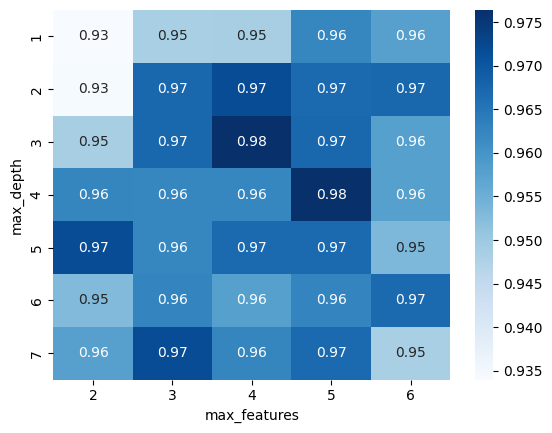

In [6]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (7, 5)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(5) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(7) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

### Logistic Regression

In [7]:
%%time
lr = LogisticRegression(max_iter = 1000)

parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear']}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=cross_validation)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.980952380952381
Best parameters: {'C': 100, 'solver': 'newton-cg'}
CPU times: total: 1.94 s
Wall time: 1.93 s


Text(50.722222222222214, 0.5, 'solver')

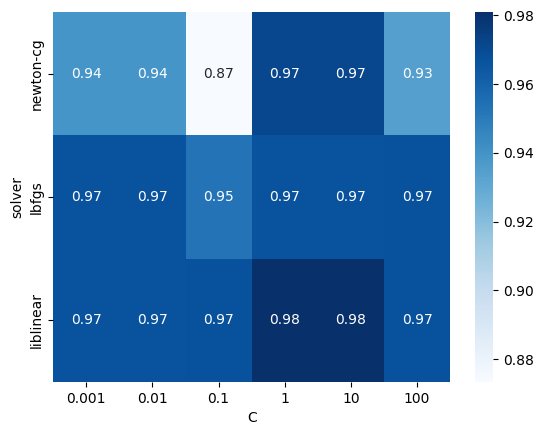

In [8]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (3, 6)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(6) + 0.5, grid_search.param_grid['C'])
plt.yticks(np.arange(3) + 0.5, grid_search.param_grid['solver'])
plt.xlabel('C')
plt.ylabel('solver')

### Random Forest Classifier

In [9]:
%%time
rfc = RandomForestClassifier()

parameter_grid = {'n_estimators' : [5, 10, 50, 100],
                    'max_depth' : [2, 3, 5, 10],
                    'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(rfc,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.980952380952381
Best parameters: {'class_weight': {0: 1, 1: 5}, 'max_depth': 5, 'n_estimators': 50}
CPU times: total: 484 ms
Wall time: 8.72 s


### SVC

In [10]:
%%time
svc = SVC(probability=True)

parameter_grid = {'C': [0.1, 1, 10, 100],
                  'gamma': [1, 0.1, 0.01, 0.001],
                  'kernel': ['rbf', 'poly', 'sigmoid']}
cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(svc,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9714285714285715
Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
CPU times: total: 359 ms
Wall time: 1.4 s


### Gradient Boosting Classifier

In [11]:
%%time
xbg = GradientBoostingClassifier()

parameter_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error', 'friedman_mse'],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[10]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(xbg,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9859307359307359
Best parameters: {'criterion': 'squared_error', 'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.390909090909091, 'n_estimators': 10, 'subsample': 0.5}
CPU times: total: 2min 8s
Wall time: 9min 37s


### Naive Bayes

In [12]:
%%time
xbg = GaussianNB()

parameter_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(xbg,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9341991341991343
Best parameters: {'var_smoothing': 1e-05}
CPU times: total: 344 ms
Wall time: 648 ms


### KNeighbors Classifier

In [13]:
%%time
knn = KNeighborsClassifier()
k_range = list(range(1, 35))
weight_options = ['uniform', 'distance']
leaf_size_options =   list(range(1, 20))
p_options = list(range(1, 10))
metric_options = ['minkowski', 'chebyshev']
    
parameter_grid = dict(n_neighbors=k_range, 
                      weights=weight_options,
                      leaf_size=leaf_size_options,
                      p=p_options,
                      metric=metric_options)

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(knn,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9668831168831169
Best parameters: {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
CPU times: total: 45.5 s
Wall time: 2min 51s


## Model Build


In [27]:
dtc = DecisionTreeClassifier(max_features=4, max_depth=3)
dtc = dtc.fit(X_train, y_train)
y_dtc = dtc.predict(X_test)
conf_dtc = confusion_matrix(y_test, y_dtc)
acc_dtc = accuracy_score(y_test, y_dtc)
prec_dtc = precision_score(y_test, y_dtc)
rec_dtc = recall_score(y_test, y_dtc)
f1_dtc = f1_score(y_test, y_dtc)
print(conf_dtc)
print(acc_dtc)
print(prec_dtc)
print(rec_dtc)
print(f1_dtc)
dtc_stats = [acc_dtc, prec_dtc, rec_dtc, f1_dtc]

[[27  0]
 [ 3 23]]
0.9433962264150944
1.0
0.8846153846153846
0.9387755102040816


Text(0.5, 1.0, 'Average score: 0.9761904761904763')

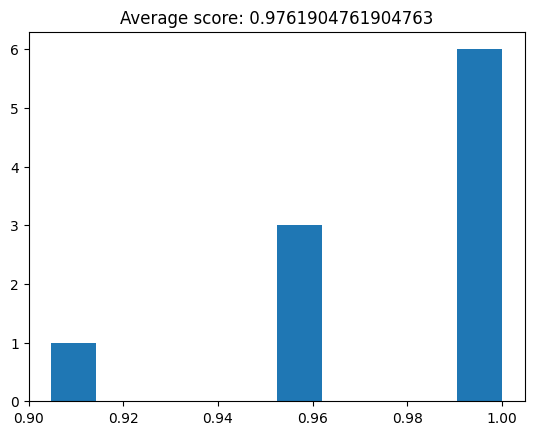

In [28]:
cv_scores = cross_val_score(dtc, X, y, cv=10)
dtc_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [29]:

logRegr = LogisticRegression(C=100, solver='newton-cg', max_iter = 1000)
logRegr.fit(X_train, y_train)
y_logRegr = logRegr.predict(X_test)
conf_logRegr = confusion_matrix(y_test, y_logRegr)
acc_logRegr = accuracy_score(y_test, y_logRegr)
prec_logRegr = precision_score(y_test, y_logRegr)
rec_logRegr = recall_score(y_test, y_logRegr)
f1_logRegr = f1_score(y_test, y_logRegr)
print(conf_logRegr)
print(acc_logRegr)
print(prec_logRegr)
print(rec_logRegr)
print(f1_logRegr)
logRegr_stats = [acc_logRegr, prec_logRegr, rec_logRegr, f1_logRegr]

[[27  0]
 [ 2 24]]
0.9622641509433962
1.0
0.9230769230769231
0.9600000000000001


Text(0.5, 1.0, 'Average score: 0.9666666666666666')

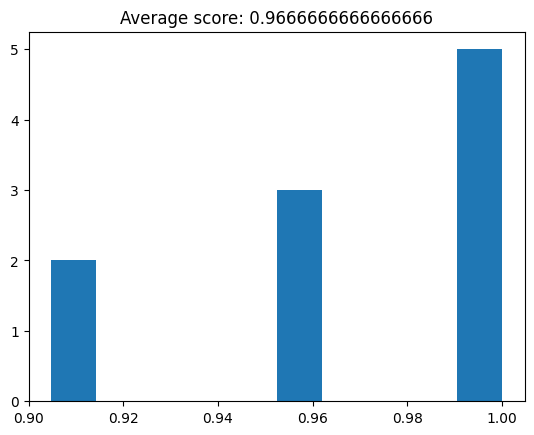

In [30]:
cv_scores = cross_val_score(logRegr, X, y, cv=10)
logRegr_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [31]:

rfc = RandomForestClassifier(class_weight = {0: 1, 1: 5}, max_depth = 5, n_estimators = 50)
rfc = rfc.fit(X_train, y_train)
y_rfc = rfc.predict(X_test)
conf_rfc = confusion_matrix(y_test, y_rfc)
acc_rfc = accuracy_score(y_test, y_rfc)
prec_rfc = precision_score(y_test, y_rfc)
rec_rfc = recall_score(y_test, y_rfc)
f1_rfc = f1_score(y_test, y_rfc)
print(conf_rfc)
print(acc_rfc)
print(prec_rfc)
print(rec_rfc)
print(f1_rfc)
rfc_stats = [acc_rfc, prec_rfc, rec_rfc, f1_rfc]

[[27  0]
 [ 0 26]]
1.0
1.0
1.0
1.0


Text(0.5, 1.0, 'Average score: 0.980952380952381')

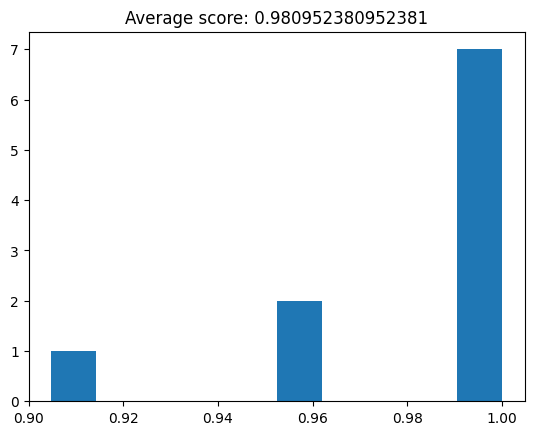

In [32]:
cv_scores = cross_val_score(rfc, X, y, cv=10)
rfc_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [33]:

svc = SVC(C=1, gamma=0.001, kernel='poly')
svc = svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)
conf_svc = confusion_matrix(y_test, y_svc)
acc_svc = accuracy_score(y_test, y_svc)
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc)
f1_svc = f1_score(y_test, y_svc)
print(conf_svc)
print(acc_svc)
print(prec_svc)
print(rec_svc)
print(f1_svc)
svc_stats = [acc_svc, prec_svc, rec_svc, f1_svc]

[[26  1]
 [ 1 25]]
0.9622641509433962
0.9615384615384616
0.9615384615384616
0.9615384615384616


Text(0.5, 1.0, 'Average score: 0.9571428571428571')

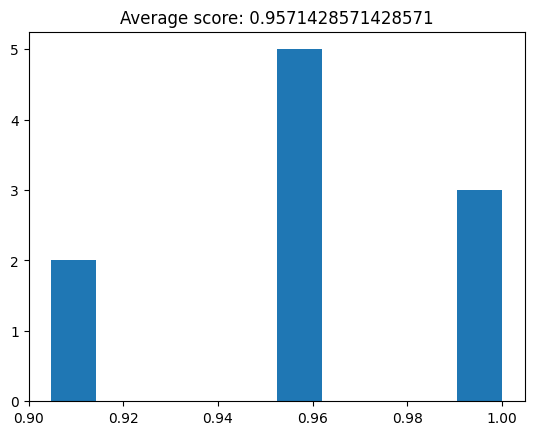

In [34]:
cv_scores = cross_val_score(svc, X, y, cv=10)
svc_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [35]:
xbg = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05, max_depth=3, max_features='sqrt', min_samples_leaf=0.1, min_samples_split=0.390909090909091, n_estimators=10, subsample=0.5)
xbg.fit(X_train, y_train)
y_xbg = xbg.predict(X_test)
conf_xbg = confusion_matrix(y_test, y_xbg)
acc_xbg = accuracy_score(y_test, y_xbg)
prec_xbg = precision_score(y_test, y_xbg)
rec_xbg = recall_score(y_test, y_xbg)
f1_xbg = f1_score(y_test, y_xbg)
print(conf_xbg)
print(acc_xbg)
print(prec_xbg)
print(rec_xbg)
print(f1_xbg)
xbg_stats = [acc_xbg, prec_xbg, rec_xbg, f1_xbg]

[[27  0]
 [ 2 24]]
0.9622641509433962
1.0
0.9230769230769231
0.9600000000000001


Text(0.5, 1.0, 'Average score: 0.9525974025974027')

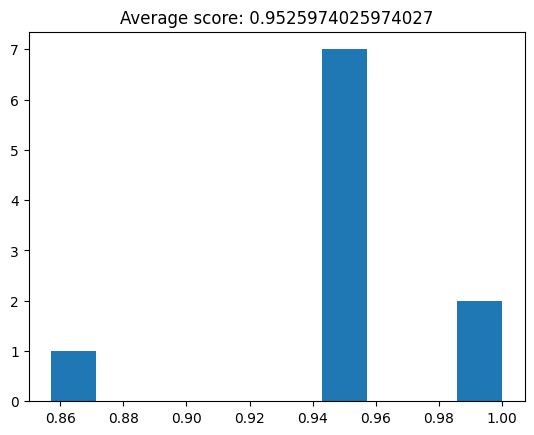

In [36]:
cv_scores = cross_val_score(xbg, X, y, cv=10)
xbg_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [37]:
nbayes = GaussianNB(var_smoothing=1e-05)
nbayes.fit(X_train, y_train)
y_nbayes = nbayes.predict(X_test)
conf_nbayes = confusion_matrix(y_test, y_nbayes)
acc_nbayes = accuracy_score(y_test, y_nbayes)
prec_nbayes = precision_score(y_test, y_nbayes)
rec_nbayes = recall_score(y_test, y_nbayes)
f1_nbayes = f1_score(y_test, y_nbayes)
print(conf_nbayes)
print(acc_nbayes)
print(prec_nbayes)
print(rec_nbayes)
print(f1_nbayes)
nbayes_stats = [acc_nbayes, prec_nbayes, rec_nbayes, f1_nbayes]

[[26  1]
 [ 4 22]]
0.9056603773584906
0.9565217391304348
0.8461538461538461
0.8979591836734695


Text(0.5, 1.0, 'Average score: 0.9480519480519481')

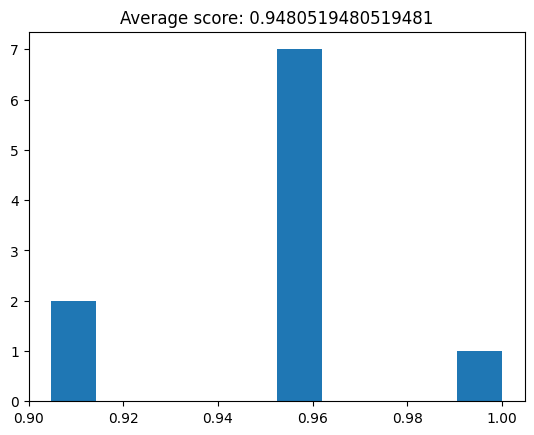

In [38]:
cv_scores = cross_val_score(nbayes, X, y, cv=10)
nbayes_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [39]:
knn = KNeighborsClassifier(leaf_size= 1, metric='minkowski', n_neighbors=6, p=1, weights='distance')
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)
conf_knn = confusion_matrix(y_test, y_knn)
acc_knn = accuracy_score(y_test, y_knn)
prec_knn = precision_score(y_test, y_knn)
rec_knn = recall_score(y_test, y_knn)
f1_knn = f1_score(y_test, y_knn)
print(conf_knn)
print(acc_knn)
print(prec_knn)
print(rec_knn)
print(f1_knn)
knn_stats = [acc_knn, prec_knn, rec_knn, f1_knn]

[[27  0]
 [ 2 24]]
0.9622641509433962
1.0
0.9230769230769231
0.9600000000000001


Text(0.5, 1.0, 'Average score: 0.9571428571428571')

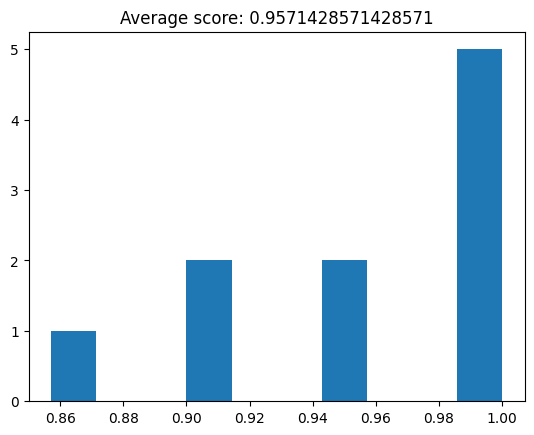

In [40]:
cv_scores = cross_val_score(knn, X, y, cv=10)
knn_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

## Comparison

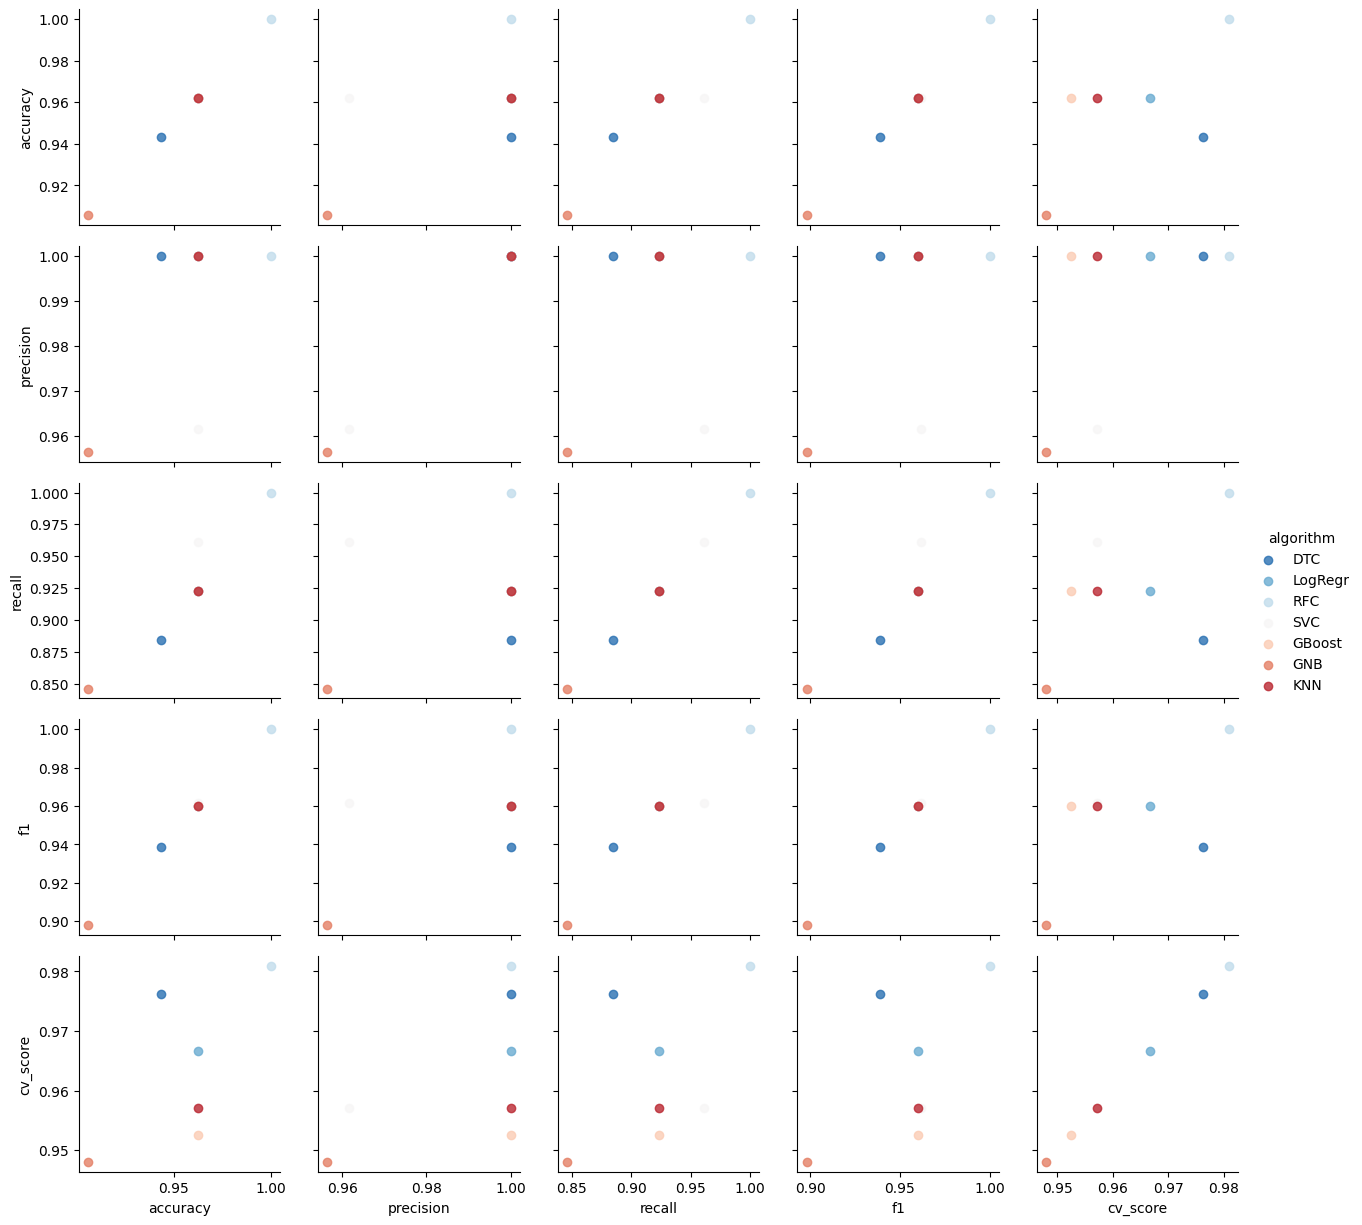

In [41]:
d = {'algorithm':['DTC', 'LogRegr', 'RFC', 'SVC', 'GBoost', 'GNB', 'KNN']}
cols = ['accuracy', 'precision', 'recall', 'f1', 'cv_score']
for i in range(0, 5):
    d[cols[i]] = [dtc_stats[i],
                   logRegr_stats[i],
                   rfc_stats[i],
                   svc_stats[i],
                   xbg_stats[i],
                   nbayes_stats[i],
                   knn_stats[i]]
comp = pd.DataFrame(data=d)
g = sns.PairGrid(comp, vars=cols,
                 hue='algorithm', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend()

In [42]:
for i in range(0, 5):
    dtc_stats[i] = round(dtc_stats[i], 3)
    logRegr_stats[i] = round(logRegr_stats[i], 3)
    rfc_stats[i] = round(rfc_stats[i], 3)
    svc_stats[i] = round(svc_stats[i], 3)
    xbg_stats[i] = round(xbg_stats[i], 3)
    nbayes_stats[i] = round(nbayes_stats[i], 3)
    knn_stats[i] = round(knn_stats[i], 3)

In [43]:
print("\tdtc\tlogRegr\trfc\tsvc\txbg\tnbayes\tknn")
values = ["acc", "prec", "rec", "f1", "cv"]
for i in range(0, 5):
    print(values[i],dtc_stats[i], logRegr_stats[i], rfc_stats[i], svc_stats[i], xbg_stats[i], nbayes_stats[i], knn_stats[i], sep='\t')

	dtc	logRegr	rfc	svc	xbg	nbayes	knn
acc	0.943	0.962	1.0	0.962	0.962	0.906	0.962
prec	1.0	1.0	1.0	0.962	1.0	0.957	1.0
rec	0.885	0.923	1.0	0.962	0.923	0.846	0.923
f1	0.939	0.96	1.0	0.962	0.96	0.898	0.96
cv	0.976	0.967	0.981	0.957	0.953	0.948	0.957
